# Preprocessing of Causal MNIST - Playground

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
from pathlib import Path

import numpy as np
from PIL import Image
import numpy as np
import os
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets.utils as dataset_utils
import normflows as nf

from gendis.datasets import CausalMNIST, ClusteredMultiDistrDataModule
from gendis.model import NeuralClusteredASCMFlow
from gendis.variational.vae import VAE

import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from gendis.noncausal.flows import (
    CouplingLayer,
    Dequantization,
    GatedConvNet,
    Reshape,
    VariationalDequantization,
    create_channel_mask,
    create_checkerboard_mask,
)
from gendis.noncausal.model import ImageFlow

In [3]:
import math
import torchvision

def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

In [25]:
# get the images
graph_type = 'chain'
root = '/Users/adam2392/pytorch_data/'
# Convert images from 0-1 to 0-255 (integers)
def discretize(sample):
    return (sample * 255).to(torch.int32)

# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor(),
                                nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
                                nf.utils.Jitter(1 / 256.0),  # apply random generation
                                # discretize,
                                torchvision.transforms.RandomRotation(350),  # get random rotations
                               ])

dataset = CausalMNIST(root=root, graph_type=graph_type, label=0, download=True, train=True, n_jobs=None, intervention_idx=None,
                     transform=transform)
dataset.prepare_dataset(overwrite=False)

img, metadata = dataset[1]
print(img.shape)



Loading dataset from "/Users/adam2392/pytorch_data/CausalMNIST/chain/chain-0-train.pt"
torch.Size([3, 28, 28])


In [28]:

img, metadata = dataset[100]
print(img.shape)

torch.Size([3, 28, 28])


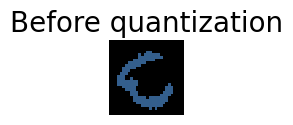

<Axes: ylabel='Count'>

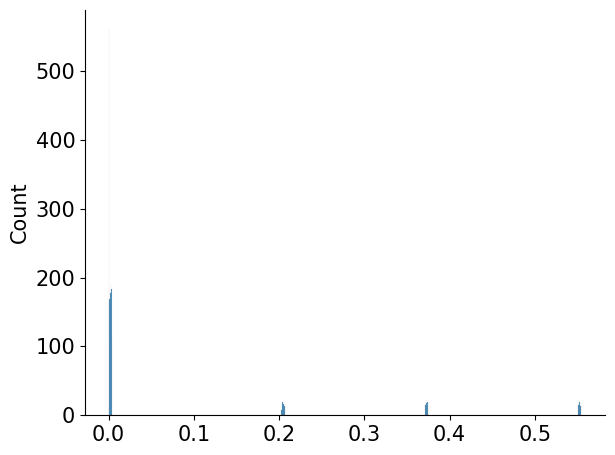

In [29]:
output = img.reshape(1, *img.shape)
show_imgs(img, title='Before quantization')
output = output.detach().numpy()
sns.histplot(output.flatten())

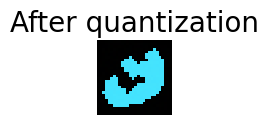

<Axes: ylabel='Count'>

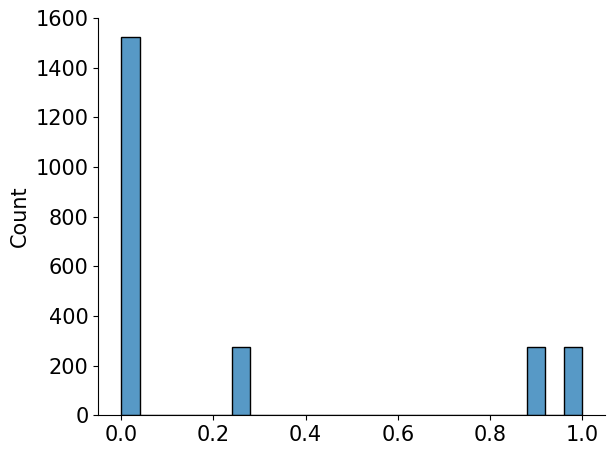

In [27]:
output = img.reshape(1, *img.shape)
output = output - output.min()
output = output / output.max()
show_imgs(output, title='After quantization')
output = output.detach().numpy()
sns.histplot(output.flatten())

In [11]:
use_vardeq = False

flow_layers = []
n_flows = 8
if use_vardeq:
    vardeq_layers = [
        CouplingLayer(
            network=GatedConvNet(c_in=6, c_out=6, c_hidden=16),
            mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
            c_in=3,
        )
        for i in range(1)
    ]
    # flow_layers += vardeq_layers
    flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
else:
    flow_layers += [Dequantization()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Running:  <class 'gendis.noncausal.flows.Dequantization'> [torch.Size([3, 28, 28])]
tensor(0.2354) tensor(-12.0929)


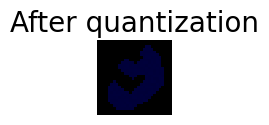

<Axes: ylabel='Count'>

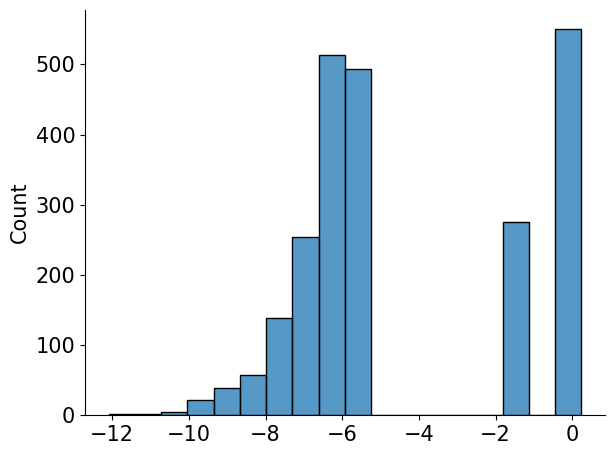

In [16]:
output = img.reshape(1, *img.shape)
ldj = 0
for flow in flow_layers:
    output, ldj = flow(output, ldj)
    print("Running: ", type(flow), [x.shape for x in output])

print(output.max(), output.min())

show_imgs(output, title='After quantization')
output = output.detach().numpy()
sns.histplot(output.flatten())

## Check quantization on regular MNIST images

In [17]:
# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor(),
                                # nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
                                nf.utils.Jitter(1 / 256.0),  # apply random generation
                                discretize,
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root='/Users/adam2392/pytorch_data/', train=True, 
                      transform=transform, 
                      download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])


Global seed set to 42


In [18]:

use_vardeq = False

flow_layers = []
n_flows = 8
if use_vardeq:
    vardeq_layers = [
        CouplingLayer(
            network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
            mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
            c_in=1,
        )
        for i in range(4)
    ]
    # flow_layers += vardeq_layers
    flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
else:
    flow_layers += [Dequantization()]

In [19]:
img = train_set[0][0]

print(img.shape)

torch.Size([1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Running:  <class 'gendis.noncausal.flows.Dequantization'> [torch.Size([1, 28, 28])]
tensor(7.5941) tensor(-12.0368)


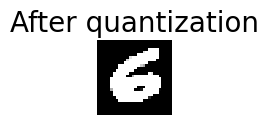

<Axes: ylabel='Count'>

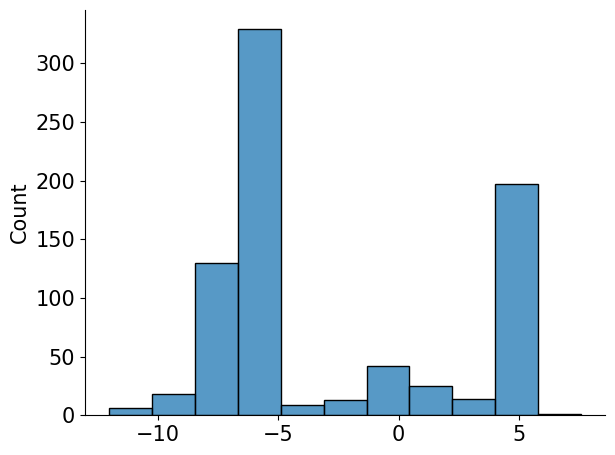

In [20]:
output = img.reshape(1, *img.shape)
ldj = 0
for flow in flow_layers:
    output, ldj = flow(output, ldj)
    print("Running: ", type(flow), [x.shape for x in output])

print(output.max(), output.min())

show_imgs(output, title='After quantization')
output = output.detach().numpy()
sns.histplot(output.flatten())